# Session clustering based on trial modes

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [136]:
path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# all_sequences = pd.read_parquet(seq_path+'all_sequences_09-22-2025')
# trial_modes = pd.read_parquet(path+'trial_clusters')
trial_modes = pd.read_parquet(path+'7_cluster_per_trial')

In [137]:
def split_sessions(all_sequences, n_parts):

    rng = np.random.default_rng() 
    all_sequences['session_part'] = np.zeros(len(all_sequences))
    for s, session in enumerate(all_sequences.session.unique()):
        session_df = all_sequences.loc[all_sequences['session']==session]
        n_trials = len(session_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        all_sequences.loc[all_sequences['session']==session, 'session_part'] = parts
    # Assign to new column
    all_sequences['session_part'] = all_sequences['session_part'].astype(str)
    # all_sequences = all_sequences.rename(columns={"sample": "trial_id"})
    all_sequences['session_part_sample'] = all_sequences[['session', 'session_part']].agg(' '.join, axis=1)
    split_session_df = all_sequences.copy()
    return split_session_df

def get_fraction_vectors(trial_clusters, target_length):

    all_sequences = pd.DataFrame(columns=['session_part', 'mouse_name', 'session', 'trial_type', 'trial_cluster', 'bin'])
    for s, session in enumerate(trial_clusters['session'].unique()):

        # Get session data and order trials
        session_data = trial_clusters.loc[trial_clusters['session']==session]
        session_data = session_data[['session_part', 'mouse_name', 'session', 'trial_id', 'trial_type', 'trial_cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        # Bin 
        n_trials = len(session_data)
        # Assign bin index: split into 10 parts
        bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
        session_data['bin'] = bin_indices
        
        all_sequences = pd.concat([all_sequences, session_data[['session_part', 'mouse_name', 'session', 
                                                                'trial_type', 'trial_cluster', 'bin']]], ignore_index=True)

    fractions = all_sequences.groupby(['session_part', 'mouse_name', 'session',
                                    'bin'])['trial_cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'trial_cluster'])
    design_df = fractions.pivot(index=['mouse_name', 'session_part', 'session'], columns=['bin', 'trial_cluster'], values='fraction').reset_index().fillna(0)
    
    return design_df

    
def prepare_design_mat(design_df):
    decoded_var = 'mouse_name'
    var = 'fact_var'

    mat = pd.DataFrame(design_df)
    mat['fact_var'] = pd.factorize(design_df[decoded_var])[0]
    mat[decoded_var] = design_df[decoded_var]

    use_labels = mat['fact_var'].unique()

    session_mouse_names = mat.loc[mat['fact_var'].isin(use_labels), decoded_var]
    session_names = pd.factorize(design_df['session'])[0]
    named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
    use_mat_pre = mat.loc[mat['fact_var'].isin(use_labels)]
    array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))
    use_mat = pd.DataFrame(array_mat[:, :-1])
    use_mat[var] = use_mat_pre[var]
    
    return use_mat, named_labels, session_mouse_names, session_names 

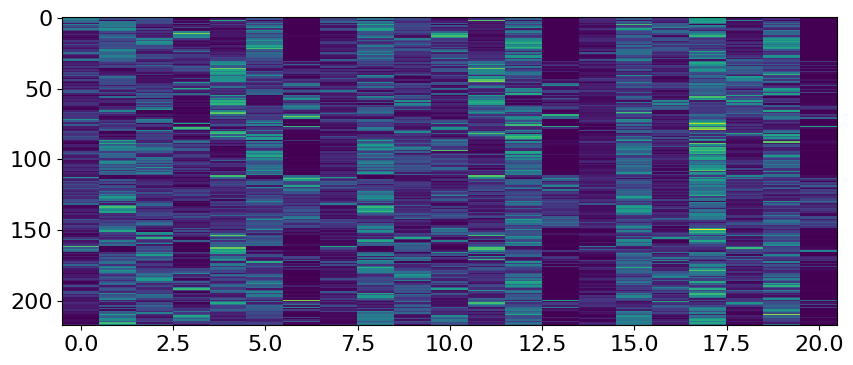

In [138]:
# Split data anew
split_session_df = split_sessions(trial_modes, 2)
split_session_df['trial_id'] = split_session_df['sample'].str.split().str[1:2].str.join('')
# split_session_df = split_session_df.sort_values(by=['mouse_name', 'session'])
split_session_df = split_session_df.loc[split_session_df['session_part']=='0.0']  # Use only one sample per session each time
fractions = get_fraction_vectors(split_session_df, 3)

plt.figure(figsize=(10, 4))
plt.imshow(np.array(fractions)[:, 3:].astype(float), aspect='auto', cmap='viridis', interpolation='none')
# plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

## Repeated samplings

In [139]:
n_parts = 2
repeats = 50


In [140]:
samplings_df = pd.DataFrame(columns=['repeat', 'matrix', 'distance_matrix'], index=range(repeats))

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
        
    # Split data anew
    split_session_df = split_sessions(trial_modes, 2)
    split_session_df['trial_id'] = split_session_df['sample'].str.split().str[1:2].str.join('')
    split_session_df = split_session_df.sort_values(by=['mouse_name', 'session'])
    split_session_df = split_session_df.loc[split_session_df['session_part']=='0.0']  # Use only one sample per session each time
    fraction_df = get_fraction_vectors(split_session_df, 3)
    fraction_df = fraction_df.sort_values(by=['mouse_name', 'session'])

    use_mat, named_labels, session_mouse_names, session_names = prepare_design_mat(fraction_df)
    pairwise_matrix = pairwise_distances(use_mat.drop(columns='fact_var'), metric='cosine')

    # Save results
    samplings_df.loc[r, 'repeat'] = r
    samplings_df.loc[r, 'matrix'] = np.array(use_mat.drop(columns='fact_var'))
    samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix

Repeat 1 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 2 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 3 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 4 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 5 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 6 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 7 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 8 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 9 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 10 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 11 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 12 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 13 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 14 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 15 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 16 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 17 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 18 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 19 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 20 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 21 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 22 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 23 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 24 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 25 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 26 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 27 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 28 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 29 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 30 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 31 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 32 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 33 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 34 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 35 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 36 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 37 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 38 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 39 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 40 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 41 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 42 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 43 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 44 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 45 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 46 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 47 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 48 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 49 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


Repeat 50 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2081690361.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session_part', 'session']))


(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

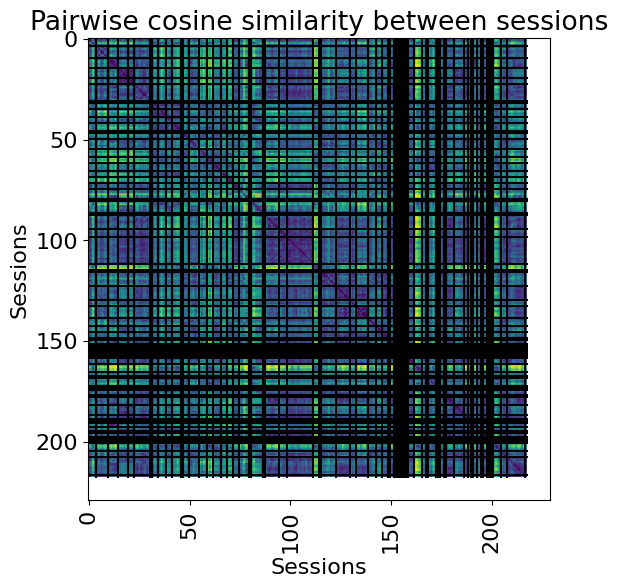

In [143]:
# fig, ax = plt.subplots(figsize=[20, 15])
fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0))
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Pairwise cosine similarity between sessions')

mouse_numbers = pd.factorize(fraction_df['mouse_name'])[0]
# mouse_numbers = session_mouse_names
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='k')
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='k')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

# plt.xlim([np.shape(samplings_df['distance_matrix'])[0], 0])
# plt.ylim([0, np.shape(samplings_df['distance_matrix'])[0]])

## Cluster each repeat and build consensus matrix

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/1640099511.py:19: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/1640099511.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this

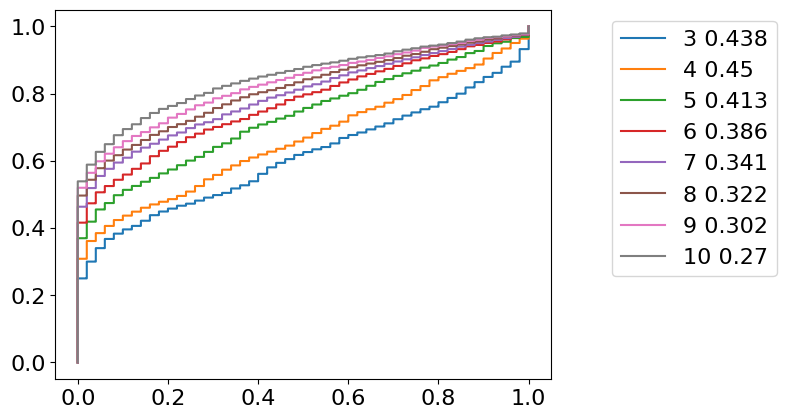

In [144]:
k = 100

# K = [3, 4, 5, 6, 7, 8, 9, 10, 13, 16]
K = [3, 4, 5, 6, 7, 8, 9, 10]
all_ks = pd.DataFrame()

samplings_df['k'] = samplings_df['repeat'] * np.nan
samplings_df['clusters'] = samplings_df['repeat'] * np.nan

for i, k in enumerate(K):
    
    samplings_df['k'] = k
    samplings_df['clusters'] = samplings_df['repeat'] * np.nan
    n_samples, _ = pairwise_matrix.shape
    consensus_matrix = np.zeros((n_samples, n_samples))

    for r in range(repeats):
        pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
        linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
        # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
        # plt.show()
        
        clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
        samplings_df['clusters'][r] = clusters 

        for i in range(n_samples):
            for j in range(i, n_samples):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
                    if i != j:
                        consensus_matrix[j, i] += 1  # symmetry
                            
    # Normalize to [0, 1]
    consensus_matrix /= repeats

    # Save
    if i == 0:
        all_ks = samplings_df
    else:
        all_ks = pd.concat([all_ks, samplings_df]) 

    # e = ECDF(consensus_matrix)
    e = ECDF(np.ravel(consensus_matrix))
    low_index = np.where(e.x>.1)[0][0]
    high_index = np.where(e.x<0.9)[0][-1]
    PAC = e.y[high_index] - e.y[low_index]
    # plt.step(e.x[::10], e.y[::10], label=str(str(k)+' '+str(PAC))) # color=palette[i],
    plt.step(e.x, e.y, label=str(str(k)+' '+str(np.round(PAC, 3)))) # color=palette[i],
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()



# Run with final k

In [160]:
k = 5
samplings_df['k'] = k
samplings_df['clusters'] = samplings_df['repeat'] * np.nan
n_samples, _ = pairwise_matrix.shape
consensus_matrix = np.zeros((n_samples, n_samples))

for r in range(repeats):
    pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
    linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
    # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
    # plt.show()
    
    clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    samplings_df['clusters'][r] = clusters 

    for i in range(n_samples):
        for j in range(i, n_samples):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1
                if i != j:
                    consensus_matrix[j, i] += 1  # symmetry
                        
# Normalize to [0, 1]
consensus_matrix /= repeats

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2415859656.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_21244/2415859656.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this 

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

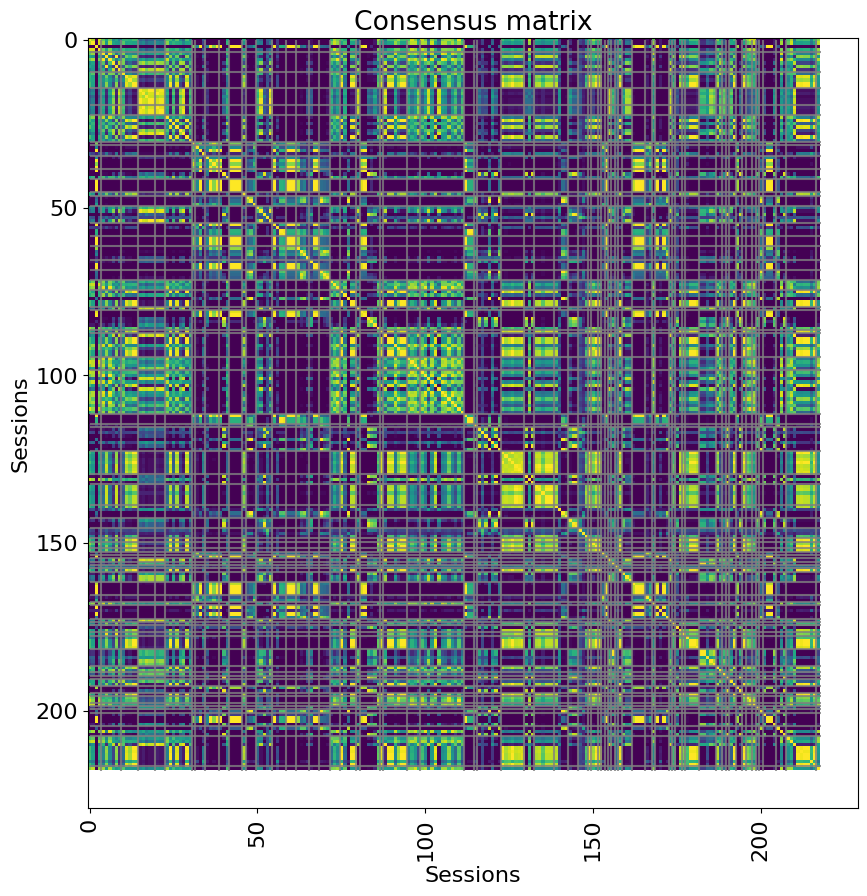

In [161]:
fig, ax = plt.subplots(figsize=[12, 10])
plt.imshow(consensus_matrix)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Consensus matrix')

mouse_numbers = pd.factorize(fraction_df['mouse_name'])[0]
# mouse_numbers = session_mouse_names
for m_lines in np.where(np.diff(mouse_numbers)==1):
    plt.vlines(m_lines+.5, 0, len(mouse_numbers), color='grey', alpha=.8)
    plt.hlines(m_lines+.5, 0, len(mouse_numbers), color='grey', alpha=.8)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)


## Save

In [172]:
filename = str(path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
all_sequences['session'] = all_sequences['sample'].str[:36]

In [173]:
def binarize(design_df):

    epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
    sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

    use_states = int(max(np.unique(use_sequences)))+1
    timesteps = np.shape(use_sequences)[1]
    binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

    for t in range(timesteps):
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(use_states))
        encoded_arr = label_binarizer.transform(use_sequences[:, t])
        binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

    return binarized

In [174]:
# Associate clusters with unsplit data; attention to sorting!!
use_sequences = all_sequences.copy()
use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = use_df.keys()[-4:]
    
use_binarized = binarize(use_df)
full_session_syllables = pd.DataFrame(use_binarized)
full_session_syllables['session'] = np.array(use_df['session'])
full_session_syllables['mouse_name'] = np.array(use_df['mouse_name'])
full_session_syllables = full_session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(use_binarized)[1], 1)].mean().reset_index()
full_session_syllables = full_session_syllables.sort_values(by=['mouse_name', 'session'])

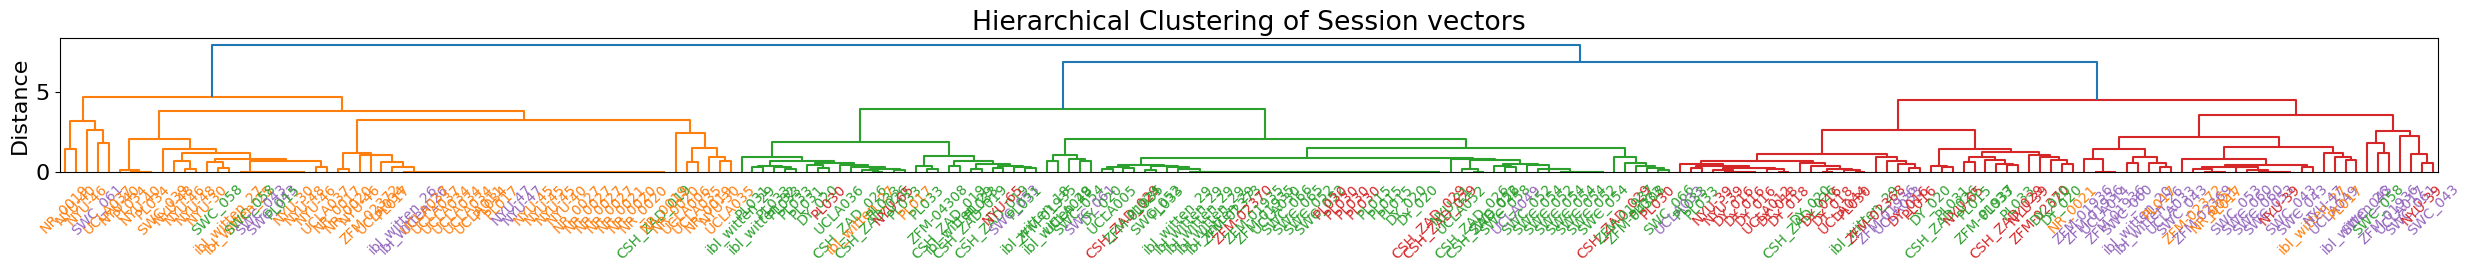

In [175]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
Z = linkage(consensus_matrix.copy(), method='average')  # You can also try 'complete', 'ward', etc.

from scipy.cluster.hierarchy import ward, fcluster
final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = final_clusters - 1

mouse_labels = np.array(fraction_df['mouse_name'])#.unique()
# design_df['session_cluster'] = clusters 

# Plot dendrogram
fig, ax = plt.subplots(figsize=(25, 3))

# Define colors for clusters
cmap = plt.get_cmap(sns.color_palette("tab10", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}

# Plot dendrogram with colored labels
dendro = dendrogram(Z, labels=mouse_labels, leaf_font_size=10, ax=ax, leaf_rotation=45)

# Apply colors to tick labels
x_labels = ax.get_xmajorticklabels()
counter = 0
for lbl in x_labels:
    mouse_id = lbl.get_text()
    cluster_id = final_clusters[mouse_labels==mouse_id][0]
    lbl.set_color(cluster_colors[cluster_id])

plt.title("Hierarchical Clustering of Session vectors")
plt.ylabel("Distance")
plt.tight_layout()

plt.show()

(array([ 5.,  0., 57.,  0.,  0., 86.,  0., 37.,  0., 33.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

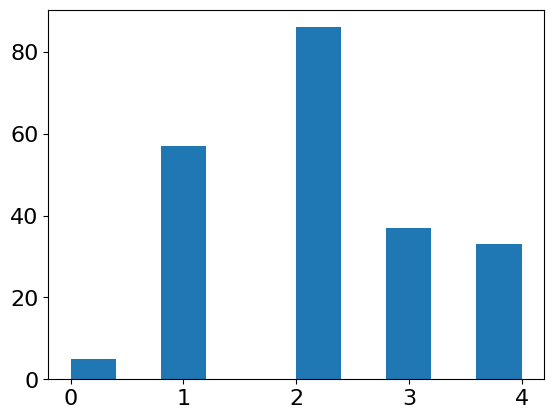

In [176]:
plt.hist(final_clusters)

In [177]:
full_session_syllables['session_cluster'] = final_clusters.copy()

## Save

In [168]:
# data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# filename = "6_trialcluster_per_session"
# full_session_syllables.to_parquet(data_path+filename)  

## Visualize

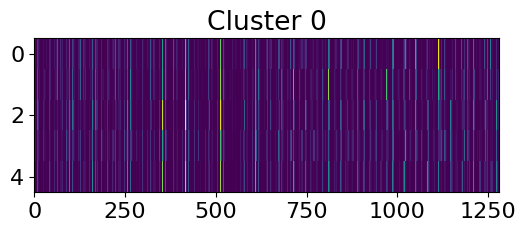

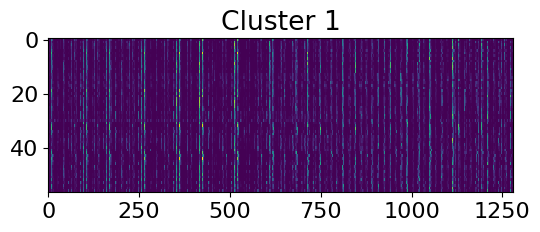

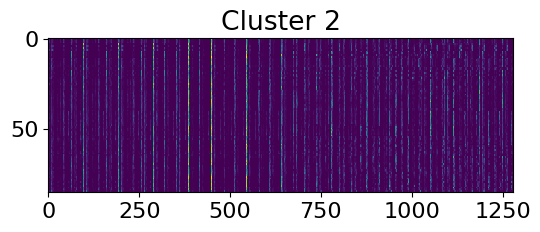

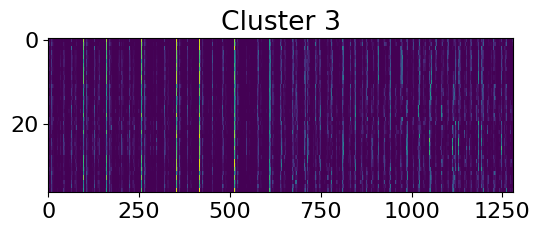

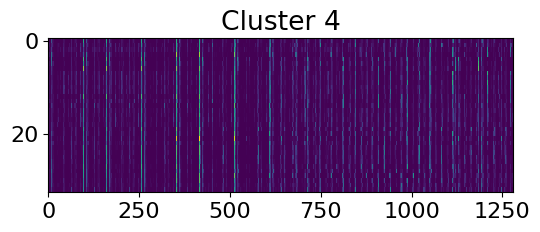

In [178]:
for c, cluster in enumerate(np.unique(final_clusters)):
    indices = np.where(final_clusters==cluster)[0]
    data = np.array(full_session_syllables[np.arange(0,np.shape(use_binarized)[1], 1)])[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    # plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

In [179]:
trial_modes.keys()
trial_modes['trial_id'] = trial_modes['sample'].str.split().str[1:2].str.join('')
trial_modes = trial_modes.merge(full_session_syllables[['session', 'session_cluster']].drop_duplicates(), on='session')


In [180]:
plot = False
target_length = 3

plot_sequences = pd.DataFrame(columns=['session', 'session_cluster', 'sample', 'trial_cluster', 'bin'])
# for s, session_part in enumerate(trial_modes['sample'].unique()):

# Get session data and order trials
# session_data = trial_modes.loc[trial_modes['sample']==session_part]
session_data = trial_modes[['session', 'trial_id', 'trial_type', 'sample', 'trial_cluster', 'session_cluster']].drop_duplicates()
session_data['trial_id'] = session_data['trial_id'].astype(float)
session_data = session_data.sort_values(by=['trial_id'])

# Bin 
n_trials = len(session_data)
# Assign bin index: split into 10 parts
bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
session_data['bin'] = bin_indices

# if plot == True:
#     states_to_append = np.arange(0, num_states)
#     for i in range(100):
#         if df_grouped['broader_label'][i] == 'Choice':
#             plot_binned_sequence(df_grouped, i, states_to_append)    
plot_sequences = pd.concat([plot_sequences, session_data[['session', 'session_cluster', 'sample',
                                                        'trial_cluster', 'bin']]], ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


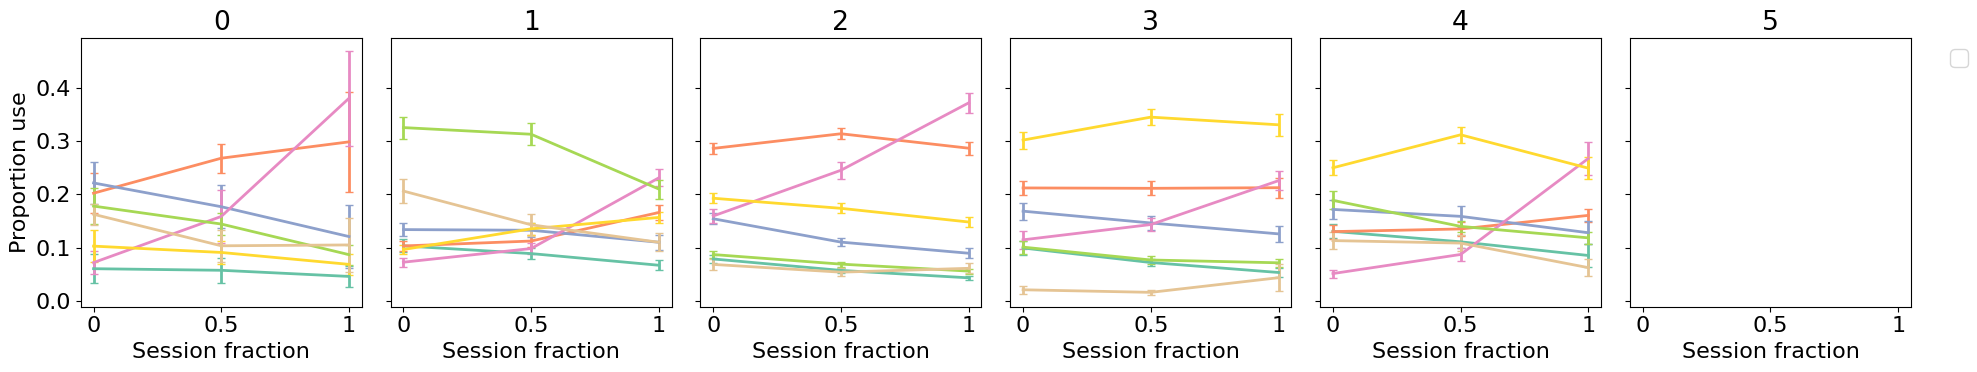

In [181]:
# palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
palette = sns.color_palette("Set2", 10, as_cmap=False)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())


fractions = plot_sequences.groupby(['session', 'session_cluster', 
                                    'bin'])['trial_cluster'].value_counts(normalize=True).rename('fraction').reset_index()
fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20, 4))

for phenotype in [0, 1, 2, 3, 4, 5]:

    # Group by bin and cluster, and compute mean and SEM
    summary = fractions.loc[fractions['session_cluster']==phenotype].groupby(['bin', 
                                                                           'trial_cluster'])['fraction'].agg(['mean', 'sem']).reset_index()
    # Ensure correct types
    summary['bin'] = summary['bin'].astype(float)
    summary['trial_cluster'] = summary['trial_cluster'].astype(float)

    # Prepare plot
    plt.rc('font', size=16)

    clusters = sorted(summary['trial_cluster'].unique())

    # Plot one line with error bars for each cluster
    for i, cluster in enumerate(clusters):
        cluster_data = summary[summary['trial_cluster'] == cluster]
        axs[phenotype].errorbar(
            cluster_data['bin'], 
            cluster_data['mean'], 
            yerr=cluster_data['sem'], 
            label=f'Trial mode {int(cluster)}',
            color=my_cmap(i),
            capsize=3,
            linewidth=2
        )

    # Customize axes
    # axs[phenotype].set_xticks([0, 1, 2, 3, 4], [0, .25, .5, .75, 1])
    axs[phenotype].set_xticks([0, 1, 2], [0, .5, 1])
    # axs[phenotype].set_xticks(sorted(fractions['bin'].unique()))
    # axs[phenotype].set_xticklabels([str(int(b)) for b in sorted(fractions['bin'].unique())])
    axs[phenotype].set_xlabel('Session fraction')
    axs[phenotype].set_title(str(phenotype))
axs[0].set_ylabel('Proportion use')
axs[5].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

In [ ]:
# Choose a Seaborn palette and convert it to HEX format
palette = sns.light_palette("seagreen", 3, as_cmap=False)
colors = [f'rgba({int(r*255)},{int(g*255)},{int(b*255)},.6)' for r, g, b in palette]  # Adjust transparency if needed

# Create the figure
fig = go.Figure()

# Add traces with custom colors and dark grey contours
for i in range(3):  # Assuming 3 clusters
    fig.add_trace(go.Scatterpolar(
        r=pd.Series(mean_cluster_parts.sort_values(by='new_clusters')
                    .loc[mean_cluster_parts['part_cluster'] == i, 'relative_frequency'].values),
        theta=plt_vars,
        fill='toself',
        name=f'Fingerprint {i}',
        line=dict(color='darkgrey', width=2),  # Dark grey contour
        fillcolor=colors[i]  # Assign Seaborn fill colors
    ))

# Update layout
fig.update_layout(
    polar=dict(
        angularaxis=dict(tickfont=dict(size=16)),  # Set font size for theta labels
        radialaxis=dict(visible=True, tickfont=dict(size=16))
    ),
    showlegend=True
)

fig.show()